In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Color palette (Framna styling)
FRAMNA_BACKGROUND = "#FFFFFF"
FRAMNA_BLACK = "#000000"
FRAMNA_GREEN = "#1CB65D"
FRAMNA_BLUE = "#E3EFF1"
FRAMNA_RED = "#B20126"
COLOR_PRIMARY = "#457b9d"
COLOR_ACCENT = "#e63946"

def style_ax(ax, xlabel, ylabel, title):
    ax.set_xlabel(xlabel, fontsize=12, fontweight="medium")
    ax.set_ylabel(ylabel, fontsize=12, fontweight="medium")
    ax.set_title(title, fontsize=14, fontweight="semibold", pad=20)
    ax.grid(True, alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

df_dp = pd.read_csv("stats_2025-10-15_16-59-11.csv")
df_dp['datetime'] = pd.to_datetime(df_dp['datetime'])
df_dp.head()

df_hys = pd.read_csv("stats_2025-10-16_12-37-18.csv")
df_hys['datetime'] = pd.to_datetime(df_hys['datetime'])
df_hys.head()

df_hys.head()

,step,datetime,action,watts_on,current_temp_c,ambient_temp_c,current_spot_price_eur_kwh,heating_rate_k_per_step,cooling_coefficient,predicted_next_temp_c,predicted_cost_eur,fcr_revenue_eur,fcr_d_down_price_eur,fcr_d_up_price_eur
0,17,2025-10-16 16:52:49.171224,OFF,0.0,21.437,0,0.08868,0,0,-273.15,0.0,0,0,0
1,18,2025-10-16 17:07:50.317408,OFF,0.0,21.312,0,0.11918,0,0,-273.15,0.0,0,0,0
2,19,2025-10-16 17:22:51.435717,OFF,0.0,21.250,0,0.11918,0,0,-273.15,0.0,0,0,0
3,20,2025-10-16 17:37:52.546462,OFF,0.0,21.062,0,0.11918,0,0,-273.15,0.0,0,0,0
4,21,2025-10-16 17:52:53.691554,OFF,0.0,21.062,0,0.11918,0,0,-273.15,0.0,0,0,0


Total cost: 0.3094 EUR
Energy consumed: 2.86 kWh
Avg price paid: 0.1082 EUR/kWh


/var/folders/fh/lmktpsyd2f99h77_8mhvt4xw0000gn/T/ipykernel_42594/2728982148.py:25: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax2.grid(False, alpha=0.0)


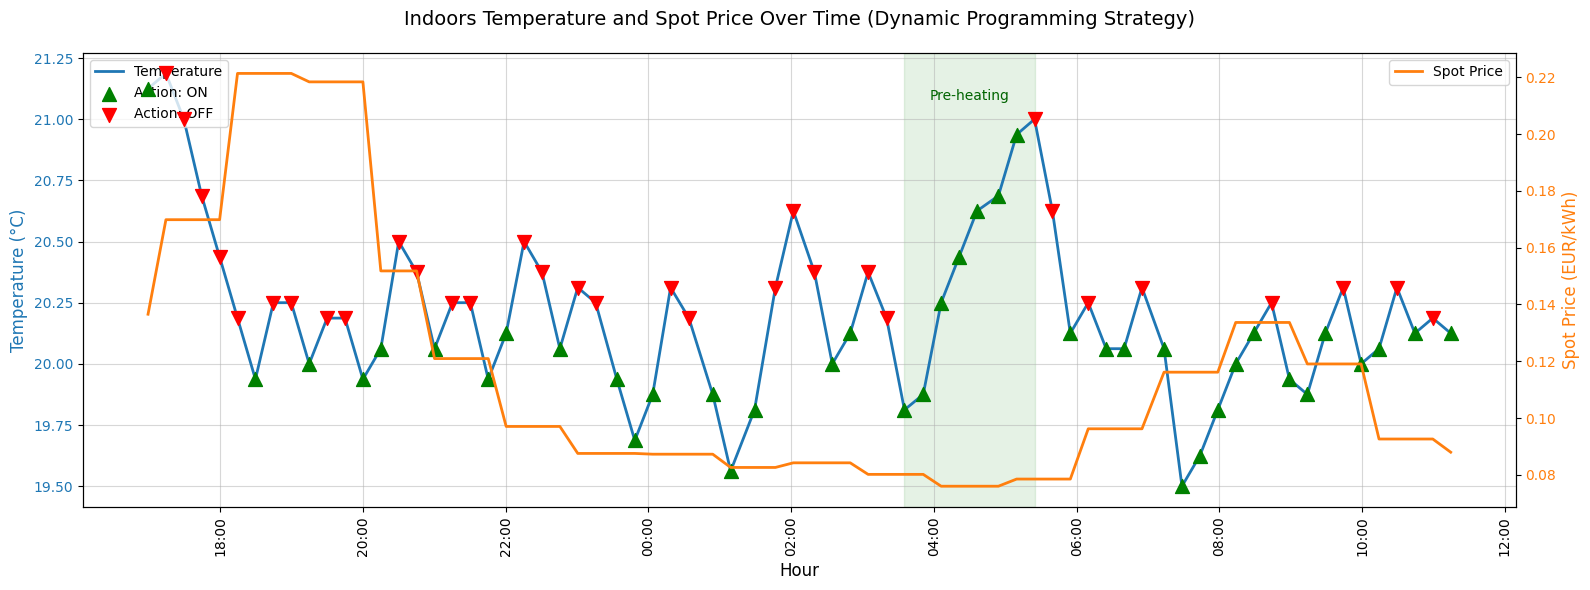

In [38]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Hour', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color=color, fontsize=12)
ax1.plot(df_dp['datetime'], df_dp['current_temp_c'], color=color, linewidth=2, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color)

# Add triangle indicators for ON/OFF actions
df_on = df_dp[df_dp['action'] == 'ON']
df_off = df_dp[df_dp['action'] == 'OFF']

ax1.scatter(df_on['datetime'], df_on['current_temp_c'], marker='^', s=100, 
            color='green', alpha=1, label='Action: ON', zorder=999)
ax1.scatter(df_off['datetime'], df_off['current_temp_c'], marker='v', s=100, 
            color='red', alpha=1, label='Action: OFF', zorder=999)

# Create a second y-axis for spot price on the right
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Spot Price (EUR/kWh)', color=color, fontsize=12)
ax2.plot(df_dp['datetime'], df_dp['current_spot_price_eur_kwh'], color=color, linewidth=2, label='Spot Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False, alpha=0.0)

# Format x-axis to show time in 24h format (HH:MM) and rotate labels
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.tick_params(axis='x', rotation=90)

# Add title and grid
plt.title('Indoors Temperature and Spot Price Over Time (Dynamic Programming Strategy)', fontsize=14, pad=20)
ax1.grid(True, alpha=0.5)

# Add pre-heating highlight region
# Define the pre-heating period (low-price hours where DP heats aggressively)
preheat_start = df_dp[(df_dp['datetime'].dt.hour == 3) & (df_dp['datetime'].dt.minute == 35)]['datetime'].min()
preheat_end = df_dp[(df_dp['datetime'].dt.hour == 5) & (df_dp['datetime'].dt.minute == 24)]['datetime'].min()

if pd.notna(preheat_start) and pd.notna(preheat_end):
    # Add shaded region for pre-heating period
    ax1.axvspan(preheat_start, preheat_end, alpha=0.1, color='green', zorder=0)
    
    # Add "Pre-heating" title at the top of the shaded region
    mid_time = preheat_start + (preheat_end - preheat_start) / 2
    y_top = ax1.get_ylim()[1]
    ax1.text(mid_time, y_top - 0.15, 'Pre-heating', 
             fontsize=10, fontweight='medium', ha='center', va='top',
             color='darkgreen')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

# Manually calculate cost from watts_on and spot price
df_dp['calculated_cost_eur'] = (df_dp['watts_on'] / 1000) * 0.25 * df_dp['current_spot_price_eur_kwh']
dp_energy_kwh = df_dp['watts_on'].sum() / 1000 * 0.25
dp_total_cost = df_dp['calculated_cost_eur'].sum()
dp_avg_price = dp_total_cost / dp_energy_kwh if dp_energy_kwh > 0 else 0

print(f"Total cost: {dp_total_cost:.4f} EUR")
print(f"Energy consumed: {dp_energy_kwh:.2f} kWh")
print(f"Avg price paid: {dp_avg_price:.4f} EUR/kWh")

plt.show()


/var/folders/fh/lmktpsyd2f99h77_8mhvt4xw0000gn/T/ipykernel_42594/3171609592.py:25: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax2.grid(False, alpha=0.0)


Total cost: 0.3389 EUR
Energy consumed: 3.15 kWh
Avg price paid: 0.1075 EUR/kWh


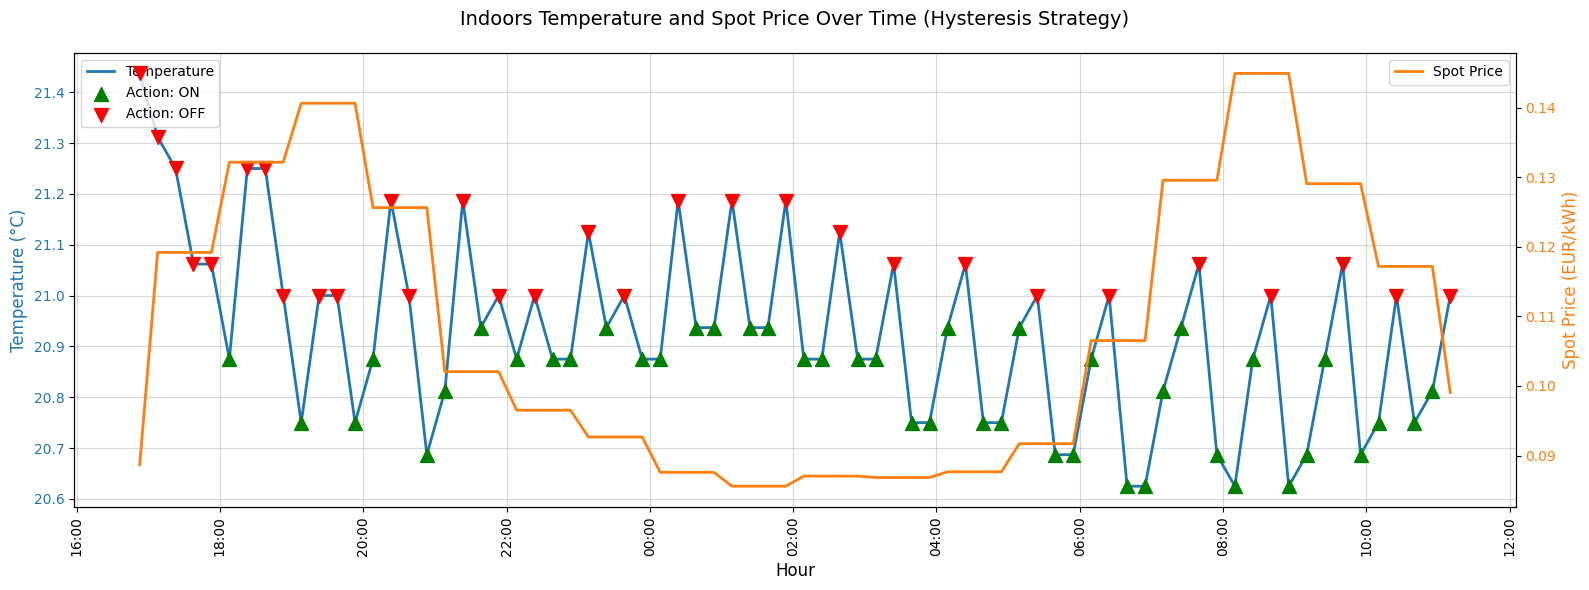

In [39]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Hour', fontsize=12)
ax1.set_ylabel('Temperature (°C)', color=color, fontsize=12)
ax1.plot(df_hys['datetime'], df_hys['current_temp_c'], color=color, linewidth=2, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color)

# Add triangle indicators for ON/OFF actions
df_on = df_hys[df_hys['action'] == 'ON']
df_off = df_hys[df_hys['action'] == 'OFF']

ax1.scatter(df_on['datetime'], df_on['current_temp_c'], marker='^', s=100, 
            color='green', alpha=1, label='Action: ON', zorder=999)
ax1.scatter(df_off['datetime'], df_off['current_temp_c'], marker='v', s=100, 
            color='red', alpha=1, label='Action: OFF', zorder=999)

# Create a second y-axis for spot price on the right
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Spot Price (EUR/kWh)', color=color, fontsize=12)
ax2.plot(df_hys['datetime'], df_hys['current_spot_price_eur_kwh'], color=color, linewidth=2, label='Spot Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False, alpha=0.0)

# Format x-axis to show time in 24h format (HH:MM) and rotate labels
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.tick_params(axis='x', rotation=90)

# Add title and grid
plt.title('Indoors Temperature and Spot Price Over Time (Hysteresis Strategy)', fontsize=14, pad=20)
ax1.grid(True, alpha=0.5)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

# Manually calculate cost from watts_on and spot price
df_hys['calculated_cost_eur'] = (df_hys['watts_on'] / 1000) * 0.25 * df_hys['current_spot_price_eur_kwh']
hys_energy_kwh = df_hys['watts_on'].sum() / 1000 * 0.25
hys_total_cost = df_hys['calculated_cost_eur'].sum()
hys_avg_price = hys_total_cost / hys_energy_kwh if hys_energy_kwh > 0 else 0

print(f"Total cost: {hys_total_cost:.4f} EUR")
print(f"Energy consumed: {hys_energy_kwh:.2f} kWh")
print(f"Avg price paid: {hys_avg_price:.4f} EUR/kWh")

plt.show()

Dynamic Programming - Total cost: 0.3094 EUR
Hysteresis - Total cost: 0.3389 EUR
Cost difference: 0.0295 EUR
Savings: 8.71%
Dynamic Programming - Energy consumed: 2.86 kWh
Hysteresis - Energy consumed: 3.15 kWh
Dynamic Programming - Avg price paid: 0.1082 EUR/kWh
Hysteresis - Avg price paid: 0.1075 EUR/kWh


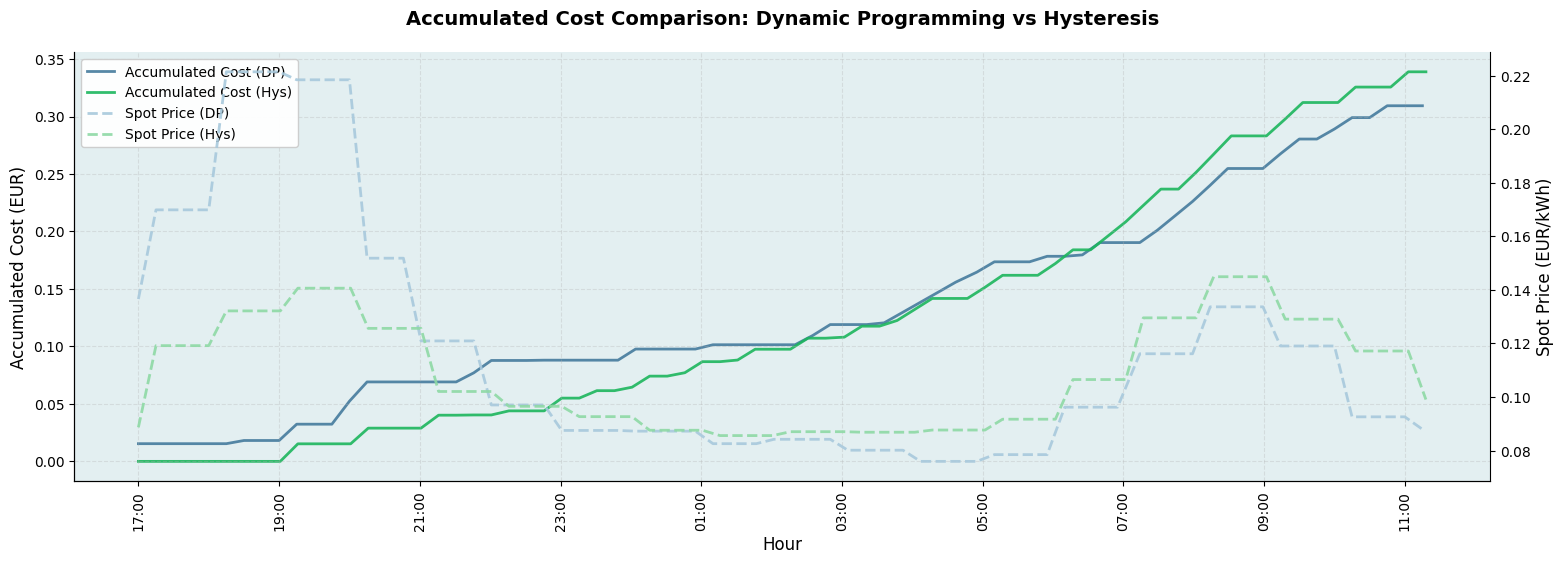

In [40]:
# Manually calculate cost from watts_on and spot price 
# cost = (watts / 1000) * hours * price_per_kwh
df_dp['calculated_cost_eur'] = (df_dp['watts_on'] / 1000) * 0.25 * df_dp['current_spot_price_eur_kwh']
df_hys['calculated_cost_eur'] = (df_hys['watts_on'] / 1000) * 0.25 * df_hys['current_spot_price_eur_kwh']

# Calculate accumulated cost over time for both strategies
df_dp['accumulated_cost'] = df_dp['calculated_cost_eur'].cumsum()
df_hys['accumulated_cost'] = df_hys['calculated_cost_eur'].cumsum()

# Create normalized time axis - extract hours and minutes, handle day wrap
# Create elapsed hours from start for both datasets
df_dp['hour_minute'] = df_dp['datetime'].dt.hour + df_dp['datetime'].dt.minute / 60
df_hys['hour_minute'] = df_hys['datetime'].dt.hour + df_hys['datetime'].dt.minute / 60

# Create elapsed time from start (handling day wrap around midnight)
start_hour_dp = df_dp['hour_minute'].iloc[0]
start_hour_hys = df_hys['hour_minute'].iloc[0]

df_dp['elapsed_hours'] = df_dp['hour_minute'].apply(lambda x: x - start_hour_dp if x >= start_hour_dp else (24 - start_hour_dp) + x)
df_hys['elapsed_hours'] = df_hys['hour_minute'].apply(lambda x: x - start_hour_hys if x >= start_hour_hys else (24 - start_hour_hys) + x)

fig, ax1 = plt.subplots(figsize=(16, 6))
fig.set_facecolor(FRAMNA_BACKGROUND)
ax1.set_facecolor(FRAMNA_BLUE)

# Plot accumulated cost on the left y-axis
# Color scheme: DP = primary blue, Hys = green
line1 = ax1.plot(df_dp['elapsed_hours'], df_dp['accumulated_cost'], color=COLOR_PRIMARY, linewidth=2, label='Accumulated Cost (DP)', alpha=0.9, zorder=1)
line2 = ax1.plot(df_hys['elapsed_hours'], df_hys['accumulated_cost'], color=FRAMNA_GREEN, linewidth=2, label='Accumulated Cost (Hys)', alpha=0.9, zorder=1)
ax1.tick_params(axis='y')

# Create a second y-axis for spot price on the right
ax2 = ax1.twinx()
ax2.set_ylabel('Spot Price (EUR/kWh)', fontsize=12, fontweight="medium")
# Plot both spot prices for comparison - lighter versions of main colors
color_price_dp = '#a8c9dc'  # Light blue for DP day spot price
color_price_hys = '#8ed9a5'  # Light green for Hys day spot price
line3 = ax2.plot(df_dp['elapsed_hours'], df_dp['current_spot_price_eur_kwh'], color=color_price_dp, linewidth=2, label='Spot Price (DP)', alpha=0.9, linestyle='--', zorder=1)
line4 = ax2.plot(df_hys['elapsed_hours'], df_hys['current_spot_price_eur_kwh'], color=color_price_hys, linewidth=2, label='Spot Price (Hys)', alpha=0.9, linestyle='--', zorder=1)
ax2.tick_params(axis='y')
ax2.grid(False)
ax2.spines["top"].set_visible(False)

# Set x-axis ticks at regular intervals and convert to time format
# Get the start time and round up to the nearest hour
start_time = df_dp['datetime'].iloc[0]
# Round up to next hour
start_time_rounded = start_time.ceil('h')
max_elapsed = int(max(df_dp['elapsed_hours'].max(), df_hys['elapsed_hours'].max())) + 2

# Create tick positions and labels
tick_positions = range(0, max_elapsed, 2)
tick_labels = []
for elapsed in tick_positions:
    # Convert elapsed hours to actual time
    time_delta = pd.Timedelta(hours=elapsed)
    actual_time = start_time_rounded + time_delta
    tick_labels.append(actual_time.strftime('%H:%M'))

ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels)
ax1.tick_params(axis='x', rotation=90)

# Apply styling to primary axis
style_ax(ax1, 'Hour', 'Accumulated Cost (EUR)', 'Accumulated Cost Comparison: Dynamic Programming vs Hysteresis')

# Combine legends from both axes
lines = line1 + line2 + line3 + line4
labels = [str(l.get_label()) for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10, framealpha=0.95)

plt.tight_layout(pad=2.0)

# Print final totals
print(f"Dynamic Programming - Total cost: {df_dp['accumulated_cost'].iloc[-1]:.4f} EUR")
print(f"Hysteresis - Total cost: {df_hys['accumulated_cost'].iloc[-1]:.4f} EUR")
print(f"Cost difference: {abs(df_dp['accumulated_cost'].iloc[-1] - df_hys['accumulated_cost'].iloc[-1]):.4f} EUR")
print(f"Savings: {((df_hys['accumulated_cost'].iloc[-1] - df_dp['accumulated_cost'].iloc[-1]) / df_hys['accumulated_cost'].iloc[-1] * 100):.2f}%")

# Total energy consumed (kWh) - assuming 15-min intervals (0.25 hours)
dp_energy_kwh = df_dp['watts_on'].sum() / 1000 * 0.25
hys_energy_kwh = df_hys['watts_on'].sum() / 1000 * 0.25

# Energy-weighted average price (actual EUR/kWh paid)
dp_weighted_price = df_dp['calculated_cost_eur'].sum() / dp_energy_kwh if dp_energy_kwh > 0 else 0
hys_weighted_price = df_hys['calculated_cost_eur'].sum() / hys_energy_kwh if hys_energy_kwh > 0 else 0

print(f"Dynamic Programming - Energy consumed: {dp_energy_kwh:.2f} kWh")
print(f"Hysteresis - Energy consumed: {hys_energy_kwh:.2f} kWh")
print(f"Dynamic Programming - Avg price paid: {dp_weighted_price:.4f} EUR/kWh")
print(f"Hysteresis - Avg price paid: {hys_weighted_price:.4f} EUR/kWh")

plt.show()
